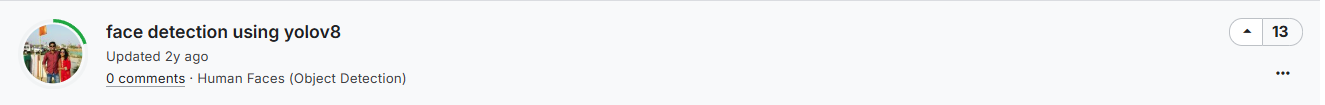

In [1]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import shutil
import cv2
import random
import matplotlib.pyplot as plt
import copy


In [2]:
import wandb
# Log in to wandb with API key
wandb.login(key='a96035366c44c4ac930354c4d3bda0f9499c339e')
# start a new wandb run to track this script
# 初始化 WandB
wandb.init(
    entity="huchencao08-shanghai-university",  # 替换为你的用户名或团队名称
    project="test",                       # 替换为你的项目名称
    config={
        "architecture": "YOLOV8",
        "epochs": 50
    }
)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Leaper\_netrc
wandb: Currently logged in as: huchencao08 (huchencao08-shanghai-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
bs=' ' # blank-space
class_id=0 # id for face
newline='\n' # new line character
extension='.txt' # extension for text file

In [4]:
# Creating paths for separate images and labels
curr_path=os.getcwd()
imgtrainpath = os.path.join(curr_path,'images','train')
imgvalpath=os.path.join(curr_path,'images','validation')
imgtestpath=os.path.join(curr_path,'images','test')

labeltrainpath=os.path.join(curr_path,'labels','train')
labelvalpath=os.path.join(curr_path,'labels','validation')
labeltestpath=os.path.join(curr_path,'labels','test')

In [5]:
# Defining data path and labels_path
data_path=r"D:\code_study\ML_CODE\dataSets\ObjectDetection\Human_Faces_Object_Detection\archive"
labels_path = os.path.join(curr_path, 'face_labels')

In [6]:
# Creating labels path
os.makedirs(labels_path)

In [7]:
# Checking input data contents
os.listdir(data_path)

['faces.csv', 'images']

In [8]:
# Defining input images and raw annotations path
img_path=os.path.join(data_path, 'images')
raw_annotations_path=os.path.join(data_path, 'faces.csv')

In [9]:
# Creating a list of all images
face_list=os.listdir(img_path)

In [10]:
face_list[:5]

['00000003.jpg',
 '00000004.jpg',
 '00000005.jpg',
 '00000006.jpg',
 '00000008.jpg']

In [11]:
data_len=len(face_list)
data_len

2204

In [12]:
random.shuffle(face_list)
# Checking if they are shuffled
face_list[:5]

['00002701.jpg',
 '00002095.jpg',
 '00002092.jpg',
 '00000230.jpg',
 '00000328.jpg']

In [13]:
train_split=0.8
val_split=0.1
test_split=0.1

In [14]:
imgtrain_list=face_list[:int(data_len*train_split)]
imgval_list=face_list[int(data_len*train_split):int(data_len*(train_split+val_split))]
imgtest_list=face_list[int(data_len*(train_split+val_split)):]

In [15]:
imgtest_list[:5] # first five images in test set

['00000099.jpg',
 '00000460.jpg',
 '00001255.jpg',
 '00002563.jpg',
 '00000809.jpg']

In [16]:
# Checking the size of train, validation and test dataset
len(imgtrain_list), len(imgval_list), len(imgtest_list)

(1763, 220, 221)

In [17]:
# function to extract basename from a file and add a different extension to it. 
def change_extension(file):
    basename=os.path.splitext(file)[0]
    filename=basename+extension
    return filename

In [18]:
labeltrain_list = list(map(change_extension, imgtrain_list)) 
labelval_list = list(map(change_extension, imgval_list)) 
labeltest_list = list(map(change_extension, imgtest_list)) 

In [19]:
# Checking if the list of text files are created correctly 
len(labeltrain_list), len(labelval_list), len(labeltest_list)

(1763, 220, 221)

In [20]:
labeltest_list[:5] # matches with the first five images of test set

['00000099.txt',
 '00000460.txt',
 '00001255.txt',
 '00002563.txt',
 '00000809.txt']

In [21]:
raw_annotations=pd.read_csv(raw_annotations_path)
raw_annotations

,image_name,width,height,x0,y0,x1,y1
0,00001722.jpg,1333,2000,490,320,687,664
1,00001044.jpg,2000,1333,791,119,1200,436
2,00001050.jpg,667,1000,304,155,407,331
3,00001736.jpg,626,417,147,14,519,303
4,00003121.jpg,626,418,462,60,599,166
...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158
3346,00002232.jpg,620,349,122,103,344,248
3347,00002232.jpg,620,349,258,118,541,303
3348,00002232.jpg,620,349,215,11,362,108


In [22]:
raw_annotations['x_centre']=0.5*(raw_annotations['x0']+raw_annotations['x1'])
raw_annotations['y_centre']=0.5*(raw_annotations['y0']+raw_annotations['y1'])
raw_annotations['bb_width']=raw_annotations['x1']-raw_annotations['x0']
raw_annotations['bb_height']=raw_annotations['y1']-raw_annotations['y0']
raw_annotations

,image_name,width,height,x0,y0,x1,y1,x_centre,y_centre,bb_width,bb_height
0,00001722.jpg,1333,2000,490,320,687,664,588.5,492.0,197,344
1,00001044.jpg,2000,1333,791,119,1200,436,995.5,277.5,409,317
2,00001050.jpg,667,1000,304,155,407,331,355.5,243.0,103,176
3,00001736.jpg,626,417,147,14,519,303,333.0,158.5,372,289
4,00003121.jpg,626,418,462,60,599,166,530.5,113.0,137,106
...,...,...,...,...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158,95.0,97.0,182,122
3346,00002232.jpg,620,349,122,103,344,248,233.0,175.5,222,145
3347,00002232.jpg,620,349,258,118,541,303,399.5,210.5,283,185
3348,00002232.jpg,620,349,215,11,362,108,288.5,59.5,147,97


In [23]:
raw_annotations['xcentre_scaled']=raw_annotations['x_centre']/raw_annotations['width']
raw_annotations['ycentre_scaled']=raw_annotations['y_centre']/raw_annotations['height']
raw_annotations['width_scaled']=raw_annotations['bb_width']/raw_annotations['width']
raw_annotations['height_scaled']=raw_annotations['bb_height']/raw_annotations['height']
raw_annotations

,image_name,width,height,x0,y0,x1,y1,x_centre,y_centre,bb_width,bb_height,xcentre_scaled,ycentre_scaled,width_scaled,height_scaled
0,00001722.jpg,1333,2000,490,320,687,664,588.5,492.0,197,344,0.441485,0.246000,0.147787,0.172000
1,00001044.jpg,2000,1333,791,119,1200,436,995.5,277.5,409,317,0.497750,0.208177,0.204500,0.237809
2,00001050.jpg,667,1000,304,155,407,331,355.5,243.0,103,176,0.532984,0.243000,0.154423,0.176000
3,00001736.jpg,626,417,147,14,519,303,333.0,158.5,372,289,0.531949,0.380096,0.594249,0.693046
4,00003121.jpg,626,418,462,60,599,166,530.5,113.0,137,106,0.847444,0.270335,0.218850,0.253589
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3345,00002232.jpg,620,349,4,36,186,158,95.0,97.0,182,122,0.153226,0.277937,0.293548,0.349570
3346,00002232.jpg,620,349,122,103,344,248,233.0,175.5,222,145,0.375806,0.502865,0.358065,0.415473
3347,00002232.jpg,620,349,258,118,541,303,399.5,210.5,283,185,0.644355,0.603152,0.456452,0.530086
3348,00002232.jpg,620,349,215,11,362,108,288.5,59.5,147,97,0.465323,0.170487,0.237097,0.277937


In [24]:
len(raw_annotations['image_name'].unique())

2204

In [25]:
# Getting all unique images
imgs=raw_annotations.groupby('image_name') 

In [26]:
for image in imgs:
    img_df=imgs.get_group(image[0])
    basename=os.path.splitext(image[0])[0]
    txt_file=basename+extension
    filepath=os.path.join(labels_path, txt_file)
    lines=[]
    i=1
    for index,row in img_df.iterrows():
        if i!=len(img_df):
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+str(row['height_scaled'])+newline
            lines.append(line)
        else:
            line=str(class_id)+bs+str(row['xcentre_scaled'])+bs+str(row['ycentre_scaled'])+bs+str(row['width_scaled'])+bs+ str(row['height_scaled'])
            lines.append(line)
        i=i+1
    with open(filepath, 'w') as file:
        file.writelines(lines)
        

In [27]:
# Checking the labels directory
os.listdir(labels_path)[:5]

['00000003.txt',
 '00000004.txt',
 '00000005.txt',
 '00000006.txt',
 '00000008.txt']

In [28]:
random_file=os.path.join(labels_path, os.listdir(labels_path)[4])
with open (random_file, 'r') as f:
    content=f.read()
content

'0 0.7061538461538461 0.35813148788927335 0.15076923076923077 0.17647058823529413'

In [29]:
def_size=640 # Image size for YOLOv8

In [30]:
len(os.listdir(labels_path)) # Verifying all labels are created

2204

In [31]:
# function to move files from source to detination
def move_files(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        shutil.move(filepath, dest_path)
        i=i+1
    print("Number of files transferred:", i)

In [32]:
# function to resize the images and copy the resized image to destination
def move_images(data_list, source_path, destination_path):
    i=0
    for file in data_list:
        filepath=os.path.join(source_path, file)
        dest_path=os.path.join(data_path, destination_path)
        
        if not os.path.isdir(dest_path):
            os.makedirs(dest_path)
        finalimage_path=os.path.join(dest_path, file)
        img_resized=cv2.resize(cv2.imread(filepath), (def_size, def_size))
        cv2.imwrite(finalimage_path, img_resized)
        i=i+1
    print("Number of files transferred:", i)

In [33]:
move_images(imgtrain_list, img_path, imgtrainpath)

Number of files transferred: 1763


In [34]:
move_images(imgval_list, img_path, imgvalpath)

Number of files transferred: 220


In [35]:
move_images(imgtest_list, img_path, imgtestpath)

Number of files transferred: 221


In [36]:
move_files(labeltrain_list, labels_path, labeltrainpath)

Number of files transferred: 1763


In [37]:
move_files(labelval_list, labels_path, labelvalpath)

Number of files transferred: 220


In [38]:
move_files(labeltest_list, labels_path, labeltestpath)

Number of files transferred: 221


In [39]:
len(os.listdir(labels_path)) 

0

In [40]:
shutil.rmtree(labels_path) # removing labels path as it is empty

In [41]:
ln_1='# Train/val/test sets'+newline
ln_2='train: ' +"'"+imgtrainpath+"'"+newline
ln_3='val: ' +"'" + imgvalpath+"'"+newline
ln_4='test: ' +"'" + imgtestpath+"'"+newline
ln_5=newline
ln_6='# Classes'+newline
ln_7='names:'+newline
ln_8='  0: face'
config_lines=[ln_1, ln_2, ln_3, ln_4, ln_5, ln_6, ln_7, ln_8]

In [42]:
# Creating path for config file
config_path=os.path.join(curr_path, 'config.yaml')
config_path

'd:\\code_study\\ML_CODE\\kaggle\\ObjectDetection\\Human Faces Object Detection\\face detection using yolov8\\config.yaml'

In [43]:
# Writing config file
with open(config_path, 'w') as f:
    f.writelines(config_lines)

In [44]:
# function to obtain bounding box  coordinates from text label files
def get_bbox_from_label(text_file_path):
    bbox_list=[]
    with open(text_file_path, "r") as file:
        for line in file:
            _,x_centre,y_centre,width,height=line.strip().split(" ")
            x1=(float(x_centre)+(float(width)/2))*def_size
            x0=(float(x_centre)-(float(width)/2))*def_size
            y1=(float(y_centre)+(float(height)/2))*def_size
            y0=(float(y_centre)-(float(height)/2))*def_size
            
            vertices=np.array([[int(x0), int(y0)], [int(x1), int(y0)], 
                               [int(x1),int(y1)], [int(x0),int(y1)]])
#             vertices=vertices.reshape((-1,1,2))
            bbox_list.append(vertices)      
            
    return tuple(bbox_list)

In [45]:
# defining red color in RGB to draw bounding box
red=(255,0,0) 

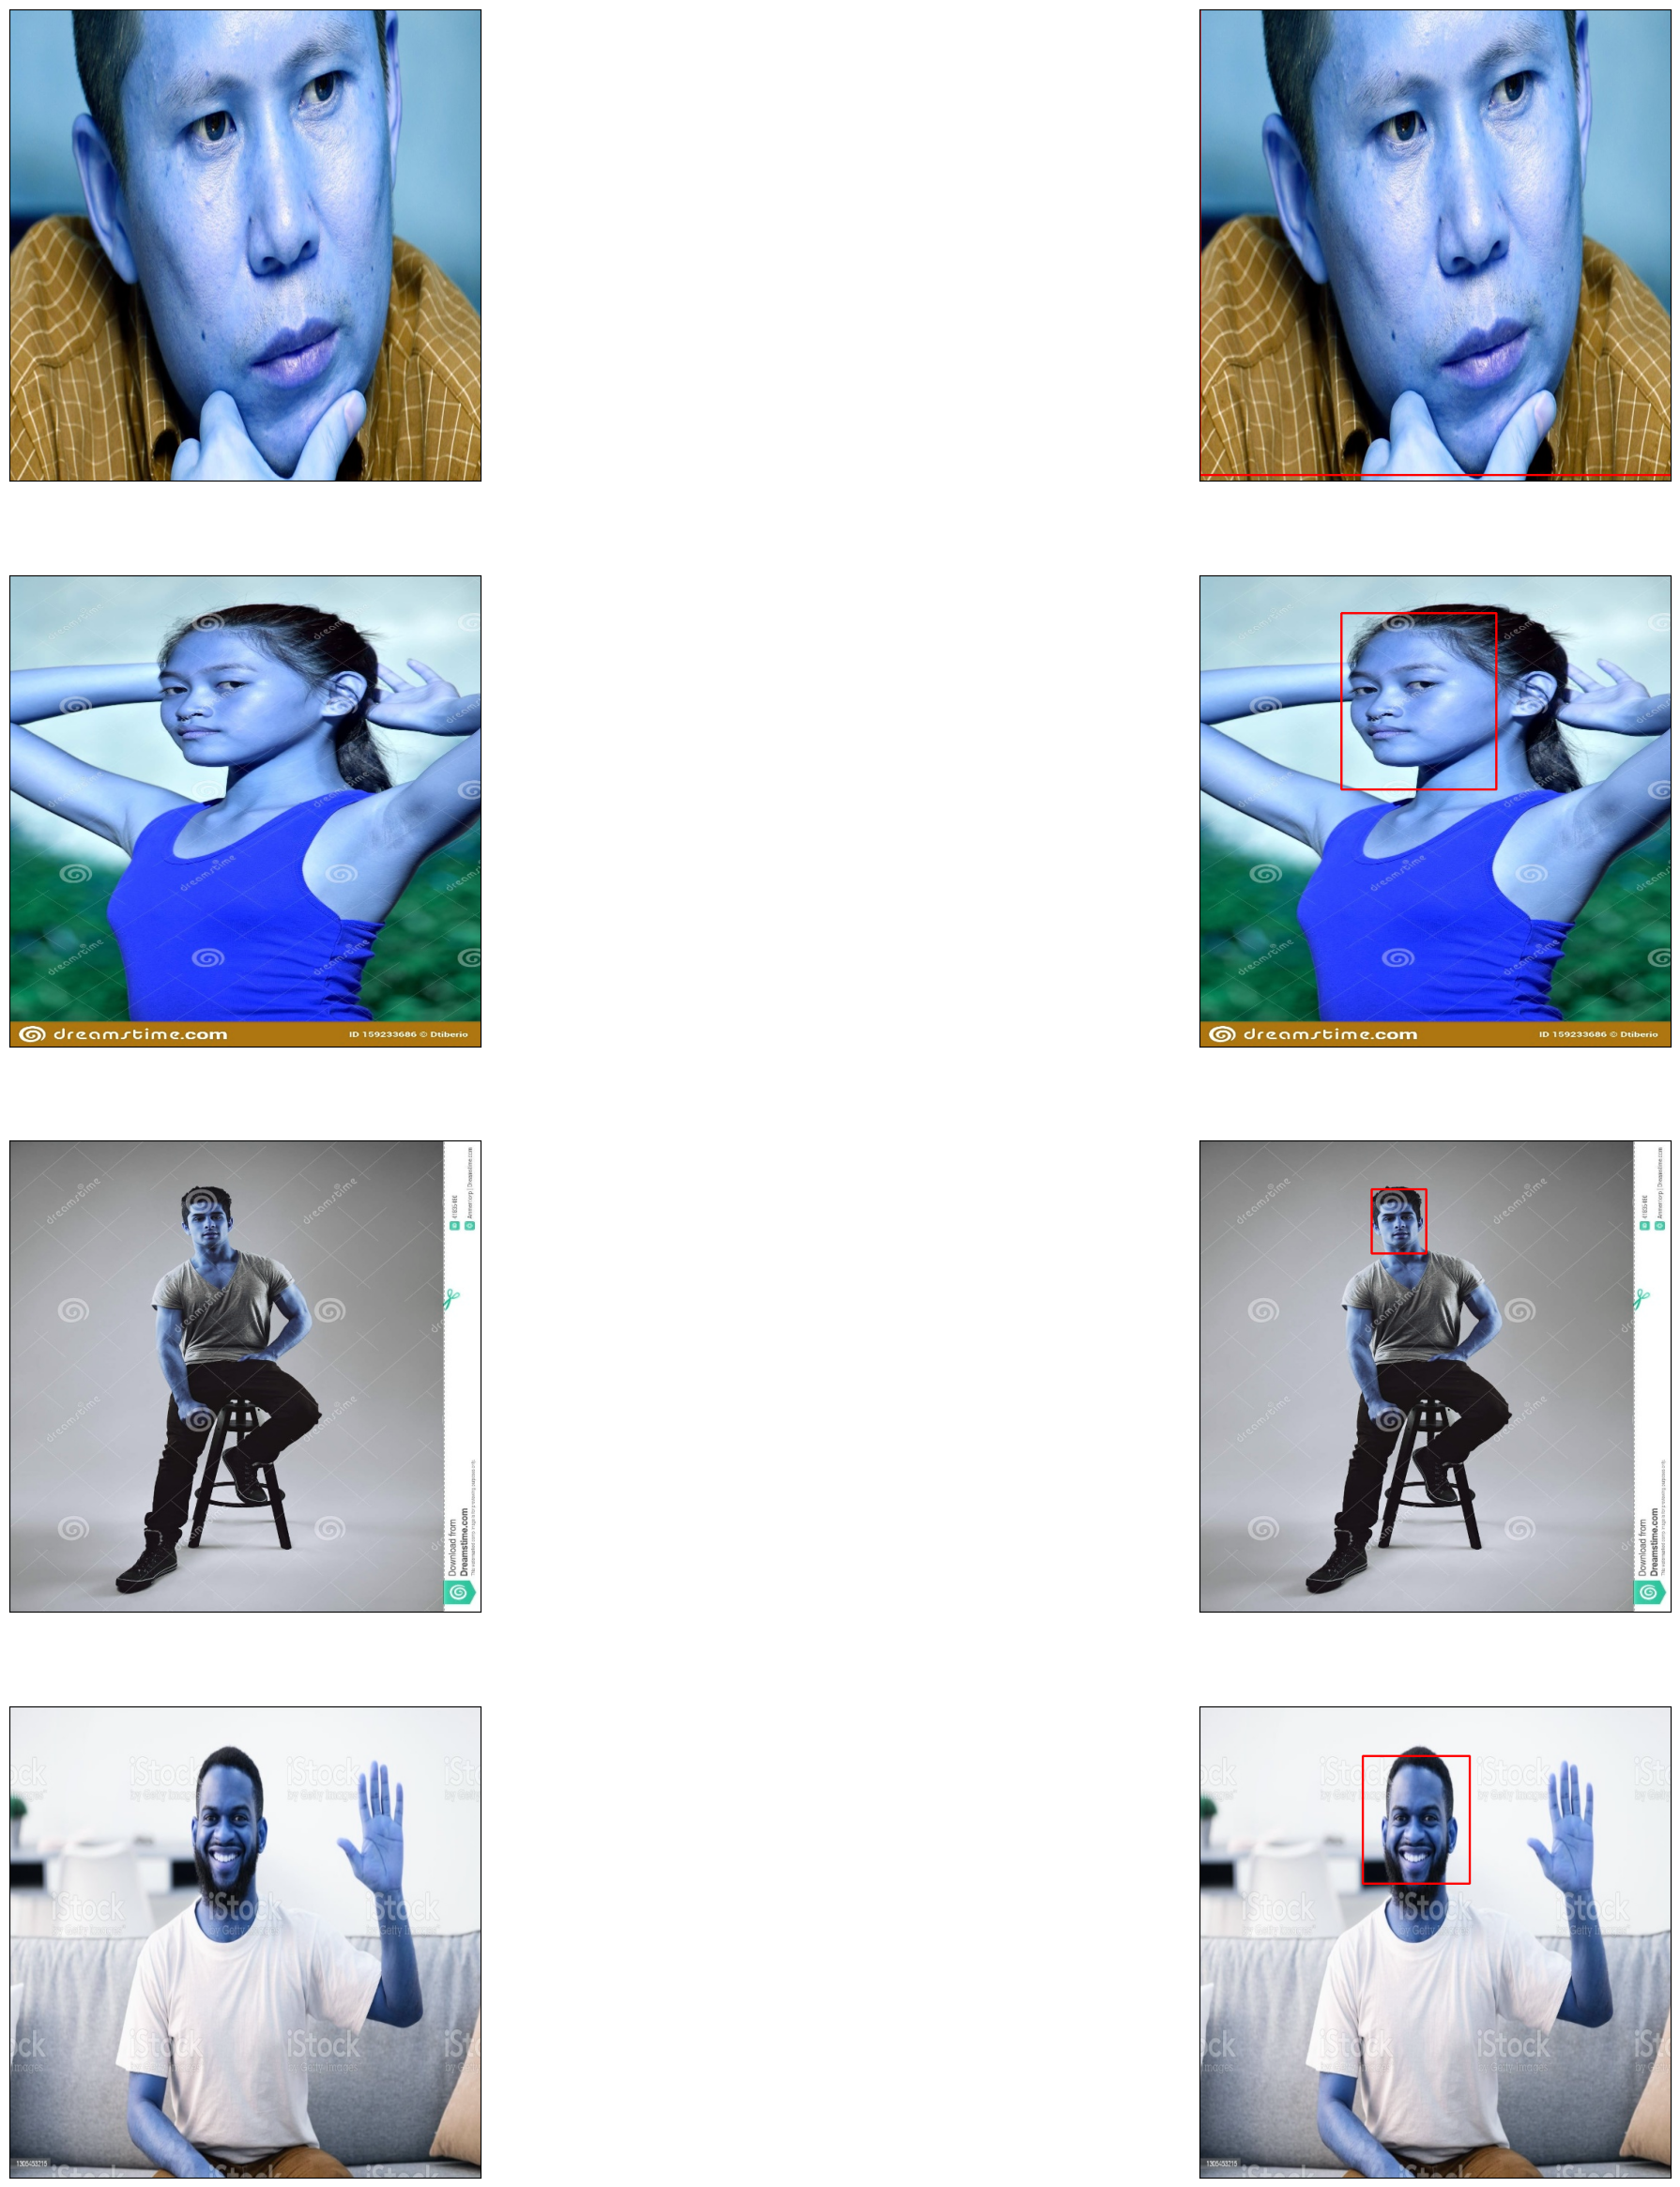

In [46]:
plt.figure(figsize=(30,30))
for i in range(1,8,2):
    k=random.randint(0, len(imgtrain_list)-1)
    img_path=os.path.join(imgtrainpath, imgtrain_list[k])
    label_path=os.path.join(labeltrainpath, labeltrain_list[k])
    bbox=get_bbox_from_label(label_path)
    image=cv2.imread(img_path)
    image_copy=copy.deepcopy(image)
    ax=plt.subplot(4, 2, i)
    plt.imshow(image) # displaying image
    plt.xticks([])
    plt.yticks([])
    cv2.drawContours(image_copy, bbox, -1, red, 2) # drawing bounding box on copy of image
    ax=plt.subplot(4, 2, i+1)
    plt.imshow(image_copy) # displaying image with bounding box
    plt.xticks([])
    plt.yticks([])

In [47]:
from ultralytics import YOLO
# Using YOLO's ptetrained model architecture and weights for training
model=YOLO('yolov8n.yaml').load('yolov8n.pt')

Transferred 355/355 items from pretrained weights
